In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from scipy.stats import t

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Configuration

In [77]:
#h1
h1_do_obs                = True
h1_do_bern               = True
resample_h1_obs          = False
resample_h1_bern         = False
folderName_h1_obs        = "h1_obs.trace"
folderName_h1_bern       = "h1_bern.trace"

#h2
h2_do_linear             = True
h2_do_quadratic          = True
resample_h2_linear       = False
resample_h2_quadratic    = False
folderName_h2_linear     = "h2_linear.trace"
folderName_h2_quadratic  = "h2_quadratic.trace"

describeData             = False

remove_rows_not_cells    = True
h1_ropes                 = [("diff_μ", (-4, -1)), ("diff_μ", (-4, -2))]
h1_bern_ropes            = [("diff_μ", (-0.8, -0.2))]
var_names_h1_notRope     = ['log10_ν', 'μ', 'σ', 'diff_σ']
var_names_h1_all         = var_names_h1_notRope.copy().extend([name for name,rope in h1_ropes])

# Helperfunctions

In [3]:
def flatten(lst):
    res = []
    for inner in lst:
        for v in inner:
            res.append(v)
    return res

def getIndexV29(): return 0
def getIndexV31(): return 1
def getIndexV33(): return 2

In [4]:
def getTrace(folder_name, model_name, resample):
    with model_name:
        if (resample):
            trace = pm.sample(10000, chains=4, cores=1, step=pm.NUTS())  #todo argue for choice
            pm.save_trace(trace, folder_name, overwrite=True)
        trace = pm.load_trace(folder_name)
        return trace

def getInferenceData(trace, model_name):
    with model_name:
        return az.from_pymc3(trace, model = model_name)

def standardize(data, m, sd):
    return (data-m)/sd

In [45]:
def plot_trace_method1(trace_inferencedata, var_names, ropes):
    az.plot_posterior(trace_inferencedata, var_names=var_names, kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);
    for (name, rope) in ropes:
        az.plot_posterior(trace_inferencedata, var_names=[name], kind='hist', figsize=(8,2.5)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=rope);

def plot_trace_method2(trace, model, var_names):
    az.plot_trace(az.from_pymc3(trace,model=model), var_names=var_names);

def plot_trace_scatter(trace, varnames):
    scatter_matrix(pm.trace_to_dataframe(trace, varnames=varnames), figsize=(20, 10));

def plot_all_data(f_x):
    fig,ax = plt.subplots(figsize=(25,20))
    xprime = np.linspace(1,5,80)
    for i in np.random.randint(0,len(trace_h2_linear),100):
        ax.plot(xprime, f_x(xprime, i), color='lightsteelblue')

    # Define spectrum of colors
    number_of_plots=len(communities)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    ax.set_prop_cycle('color', colors)

    [ax.plot(get_relevant(com, getIndexV29())[1], get_relevant(com, getIndexV31())[1], "-", marker='o', label=com) for com in communities]

    plt.legend(loc='best')
    plt.show()

# load data

In [6]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})

df = df[["id", "Community", "V29", "V31", "V33"]]
df = df[df["Community"] != "-1"]

if remove_rows_not_cells:
    for col in df.iloc[:,2:].columns:
        df = df[df[col] != -1]

In [7]:
def removeNoAnswer(lst):
    return lst if remove_rows_not_cells else [i for i in lst if i!=-1]

data = []
communities = df.Community.unique();
for com in communities:
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    
    N_bern = [len(v) for v in positive]
    μ_bern = [np.mean(v) for v in positive]
    σ_bern = [np.std(v) for v in positive]
    all = (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern)
    data.append(all)

def get_all_data ():
    return data
    
def get_relevant(com, dataIndex):
    (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern) = next(filter(lambda lst : lst[0]==com, data))
    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_bern[dataIndex], μ_bern[dataIndex], σ_bern[dataIndex])

In [8]:
df.head() if describeData else None

In [9]:
df.iloc[:,2:].describe() if describeData else None

In [10]:
if describeData:
    df.hist(column=df.columns[1:], bins=50, figsize=(20,3), layout=(1,3))
    plt.show()

### H1
The Coala Community is more lenient than the Linux Kernel Community.

#### Decision Rules - for reference
The basic principle 
 
- Decision Rule 1. If the null value is far from credible values: reject the hypothesis 
- Decision Rule 2. If all credible values are practically equivalent to the null value: accept the hypothesis 
- **Example.** If we want to prove that a coin is biased, we want to reject the null value of 0.5

Null value - draft
- The Likert scale value of Coala community is greater than that of Linux Kernel Community
- The difference is non zero - 95% HDI of difference doesn't overlap with ROPE of zero - (maybe +-.25 of the scale ~0.5%)
- Our null hypothesis is that the Coala Community is more lenient than the Linux Kernel Community if **(μ_coala - μ_linux) < -1**




In [54]:
(com_coala, obs_coala, bern_coala, N_coala_obs, μ_coala_obs, σ_coala_obs, N_coala_bern, μ_coala_bern, σ_coala_bern)=get_relevant("Comm.Coala", getIndexV33())
(com_linux, obs_linux, bern_linux, N_linux_obs, μ_linux_obs, σ_linux_obs, N_linux_bern, μ_linux_bern, σ_linux_bern)=get_relevant("Comm.Linux_Kernel", getIndexV33())

if describeData  or True:
    print("com: ",com_coala, com_linux)
    print("obs: ",obs_coala, obs_linux)
    print("N: ", N_coala_obs, N_linux_obs)
    print("μ: ", μ_coala_obs, μ_linux_obs)
    print("σ: ", σ_coala_obs, σ_linux_obs)
    print("p: ", bern_coala, bern_linux)
    print("N: ", N_coala_bern, N_linux_bern)
    print("μ: ", μ_coala_bern, μ_linux_bern)
    print("σ: ", σ_coala_bern, σ_linux_bern)

com:  Comm.Coala Comm.Linux_Kernel
obs:  [2 1 2 2 1 2 2] [2 4 4 3 3 1 2 3 2 3 3 4 3 4 2 2 3 4]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
N:  7 18
μ:  1.0 0.7222222222222222
σ:  0.0 0.4479032082388083


### H1 Model description

In [62]:
def makeModel(data_coala, data_linux, data_μ_coala, data_μ_linux, data_σ_coala, data_σ_linux):
    data_σ_coala = np.max([1/1000,data_σ_coala])
    data_σ_linux = np.max([1/1000,data_σ_linux])
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        print (data_μ_coala, data_μ_linux)
        μ        = pm.Deterministic('μ', μ_noData*[data_μ_coala, data_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[data_σ_coala, data_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

        #likelihood
        print (data_coala, data_linux)
        obs_coala   = pm.StudentT('obs_coala',  nu=ν, mu=μ[0], sd=σ[0], observed=data_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν, mu=μ[1], sd=σ[1], observed=data_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1

In [63]:
model_h1_obs  = makeModel(obs_coala,  obs_linux,  μ_coala_obs,  μ_linux_obs,  σ_coala_obs,  σ_linux_obs)  if h1_do_obs else None
model_h1_bern = makeModel(bern_coala, bern_linux, μ_coala_bern, μ_linux_bern, σ_coala_bern, σ_linux_bern) if h1_do_bern else None

1.7142857142857142 2.888888888888889
[2 1 2 2 1 2 2] [2 4 4 3 3 1 2 3 2 3 3 4 3 4 2 2 3 4]
1.0 0.7222222222222222
[1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


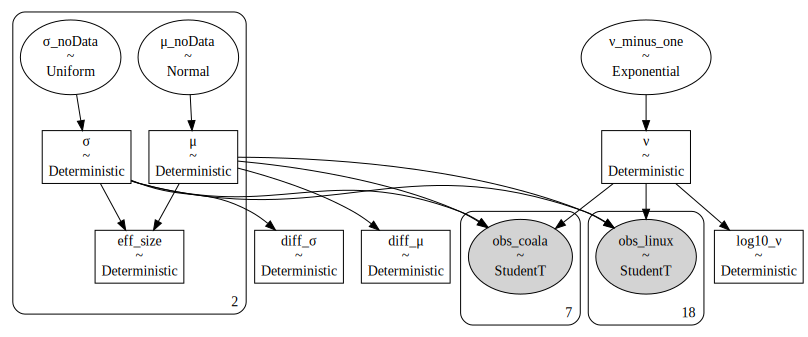

In [14]:
pm.model_to_graphviz(model_h1_obs)  if h1_do_obs else None

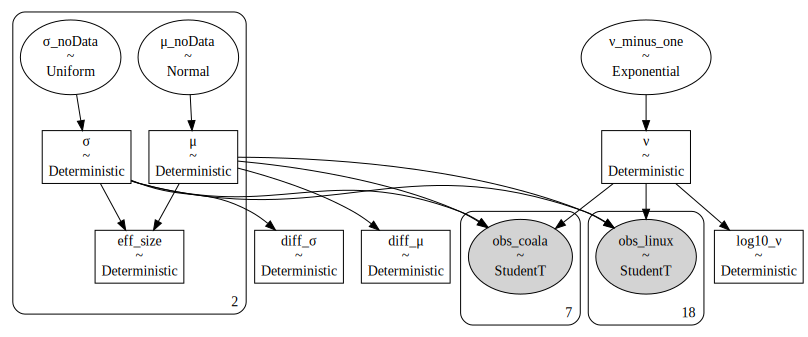

In [58]:
pm.model_to_graphviz(model_h1_bern) if h1_do_bern else None

In [16]:
trace_h1_obs = getTrace(folderName_h1_obs,  model_h1_obs,  resample_h1_obs)  if h1_do_obs else None
trace_h1_inferencedata_obs = getInferenceData(trace_h1_obs, model_h1_obs)    if h1_do_obs else None

In [59]:
trace_h1_bern = getTrace(folderName_h1_bern, model_h1_bern, resample_h1_bern) if h1_do_bern else None
trace_h1_inferencedata_bern = getInferenceData(trace_h1_bern, model_h1_bern)  if h1_do_bern else None

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.9373520790556679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.947751458489468, but should be close to 0.8. Try to increase the number of tuning steps.


### H1 Model analysis

In [18]:
az.summary(trace_h1_obs)  if h1_do_obs  else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.011,0.152,0.730,1.291,0.001,0.001,14935.0,14935.0,23257.0,18001.0,1.0
μ_noData[1],1.002,0.082,0.844,1.154,0.000,0.000,29770.0,29770.0,30195.0,24207.0,1.0
μ[0],1.733,0.260,1.252,2.213,0.002,0.002,14935.0,14935.0,23257.0,18001.0,1.0
μ[1],2.895,0.238,2.437,3.332,0.001,0.001,29770.0,29770.0,30195.0,24207.0,1.0
σ_noData[0],1.355,0.605,0.555,2.409,0.005,0.004,12544.0,11177.0,11811.0,6771.0,1.0
σ_noData[1],1.081,0.218,0.711,1.488,0.001,0.001,26922.0,25603.0,28268.0,25088.0,1.0
σ[0],0.612,0.274,0.251,1.088,0.002,0.002,12544.0,11177.0,11811.0,6771.0,1.0
σ[1],0.946,0.191,0.622,1.302,0.001,0.001,26922.0,25603.0,28268.0,25088.0,1.0
ν_minus_one,35.320,30.219,0.447,89.258,0.169,0.120,32001.0,31653.0,15490.0,6733.0,1.0
ν,36.320,30.219,1.447,90.258,0.169,0.120,32001.0,31681.0,15490.0,6733.0,1.0


In [60]:
az.summary(trace_h1_bern) if h1_do_bern else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,34127.0,34127.0,38175.0,24758.0,1.0
μ_noData[1],1.385000e+00,0.000000e+00,1.384000e+00,1.385000e+00,0.000,0.000,24100.0,24098.0,27124.0,20364.0,1.0
μ[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,34127.0,34127.0,38175.0,24758.0,1.0
μ[1],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,24100.0,24098.0,27124.0,20364.0,1.0
σ_noData[0],1.000000e-03,0.000000e+00,1.000000e-03,2.000000e-03,0.000,0.000,32699.0,29277.0,28822.0,18129.0,1.0
σ_noData[1],1.000000e-03,0.000000e+00,1.000000e-03,2.000000e-03,0.000,0.000,29554.0,25992.0,27390.0,19441.0,1.0
σ[0],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,32699.0,29277.0,28822.0,18129.0,1.0
σ[1],1.000000e-03,0.000000e+00,0.000000e+00,1.000000e-03,0.000,0.000,29554.0,25992.0,27390.0,19441.0,1.0
ν_minus_one,3.600000e-02,3.600000e-02,0.000000e+00,1.020000e-01,0.000,0.000,37138.0,35897.0,23433.0,14893.0,1.0
ν,1.036000e+00,3.600000e-02,1.000000e+00,1.102000e+00,0.000,0.000,37138.0,37138.0,23433.0,14893.0,1.0


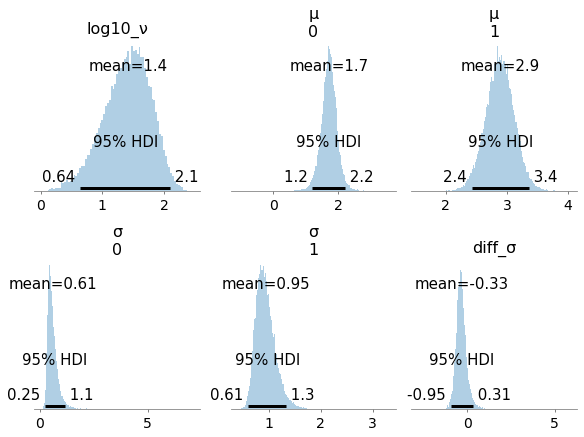

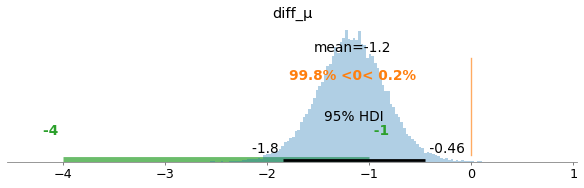

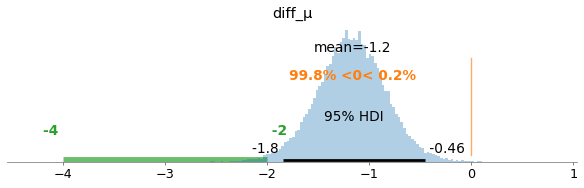

In [78]:
plot_trace_method1(trace_h1_inferencedata_obs,  var_names_h1_notRope, h1_ropes) if h1_do_obs  else None

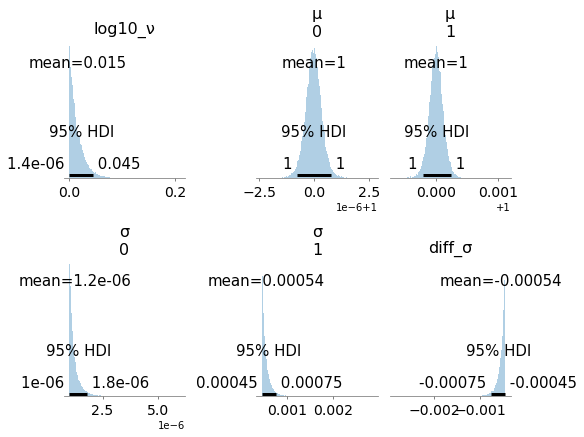

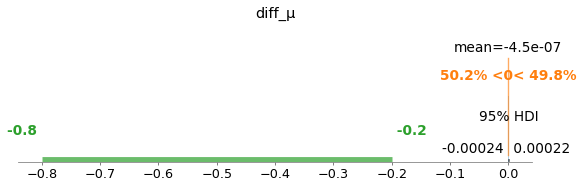

In [61]:
plot_trace_method1(trace_h1_inferencedata_bern, var_names_h1_notRope, h1_bern_ropes) if h1_do_bern else None

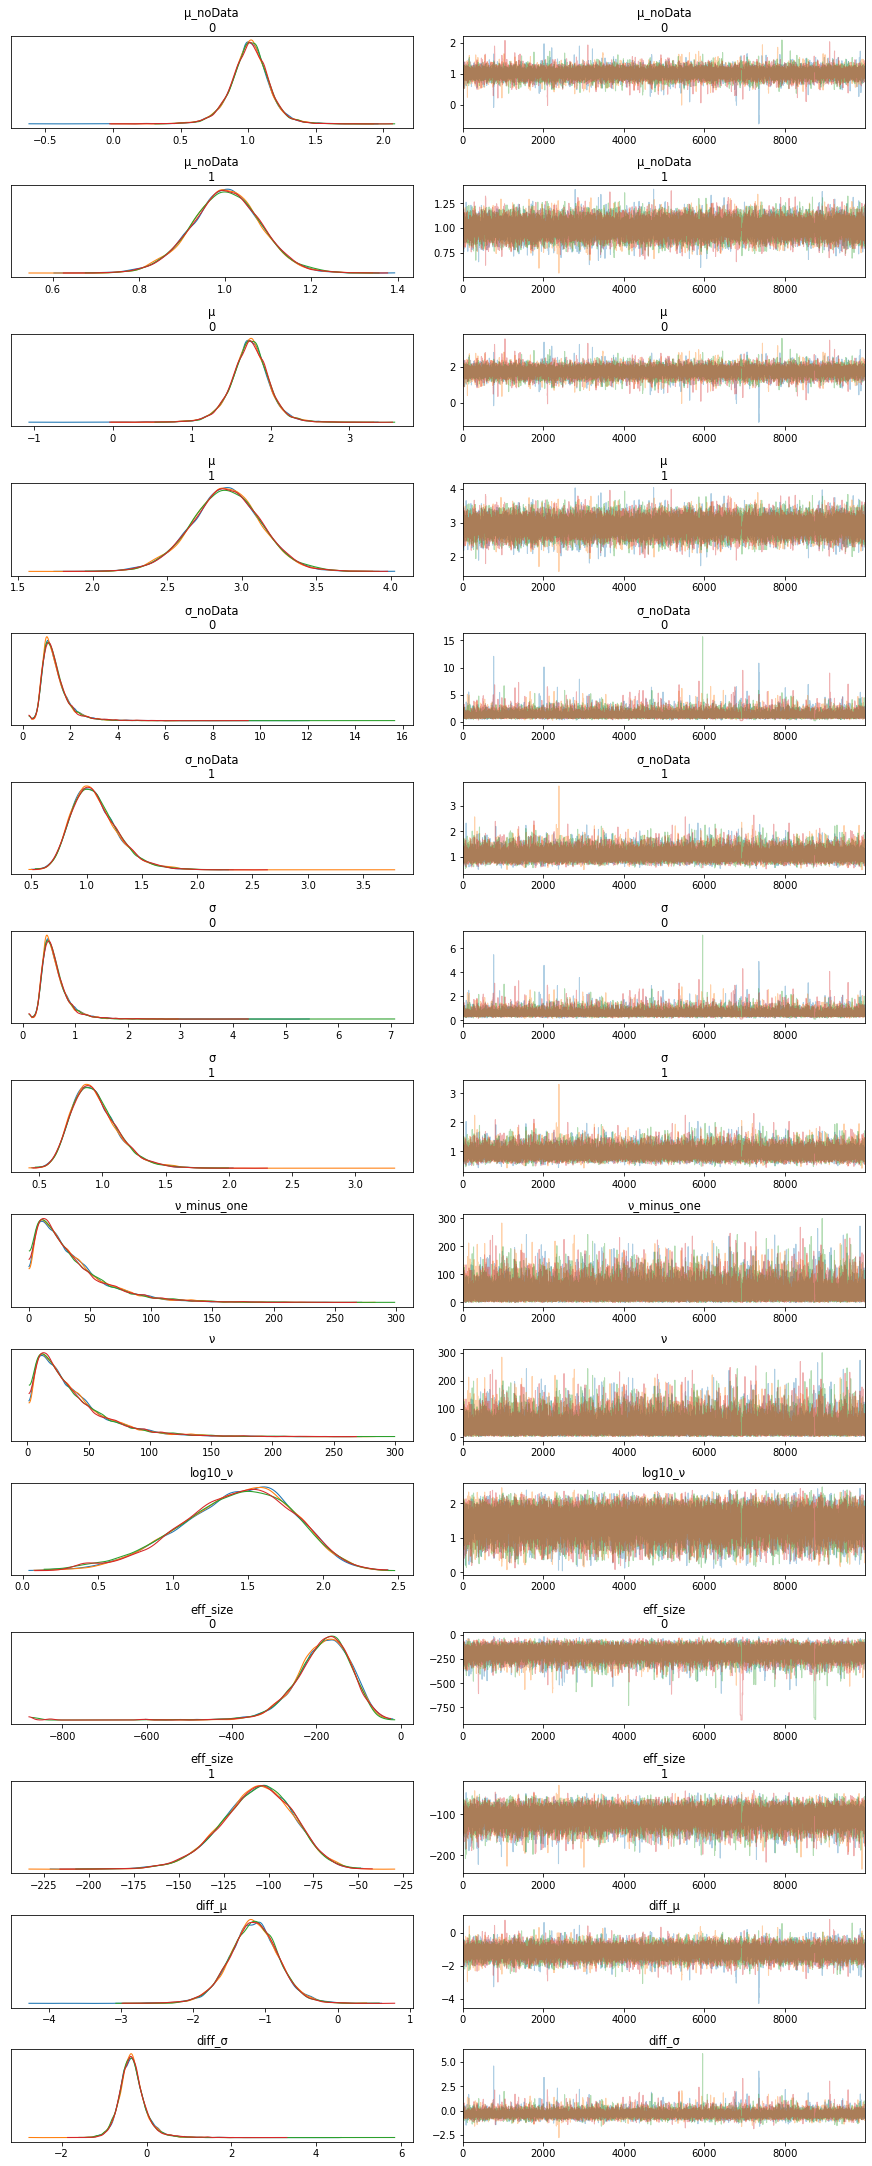

In [22]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

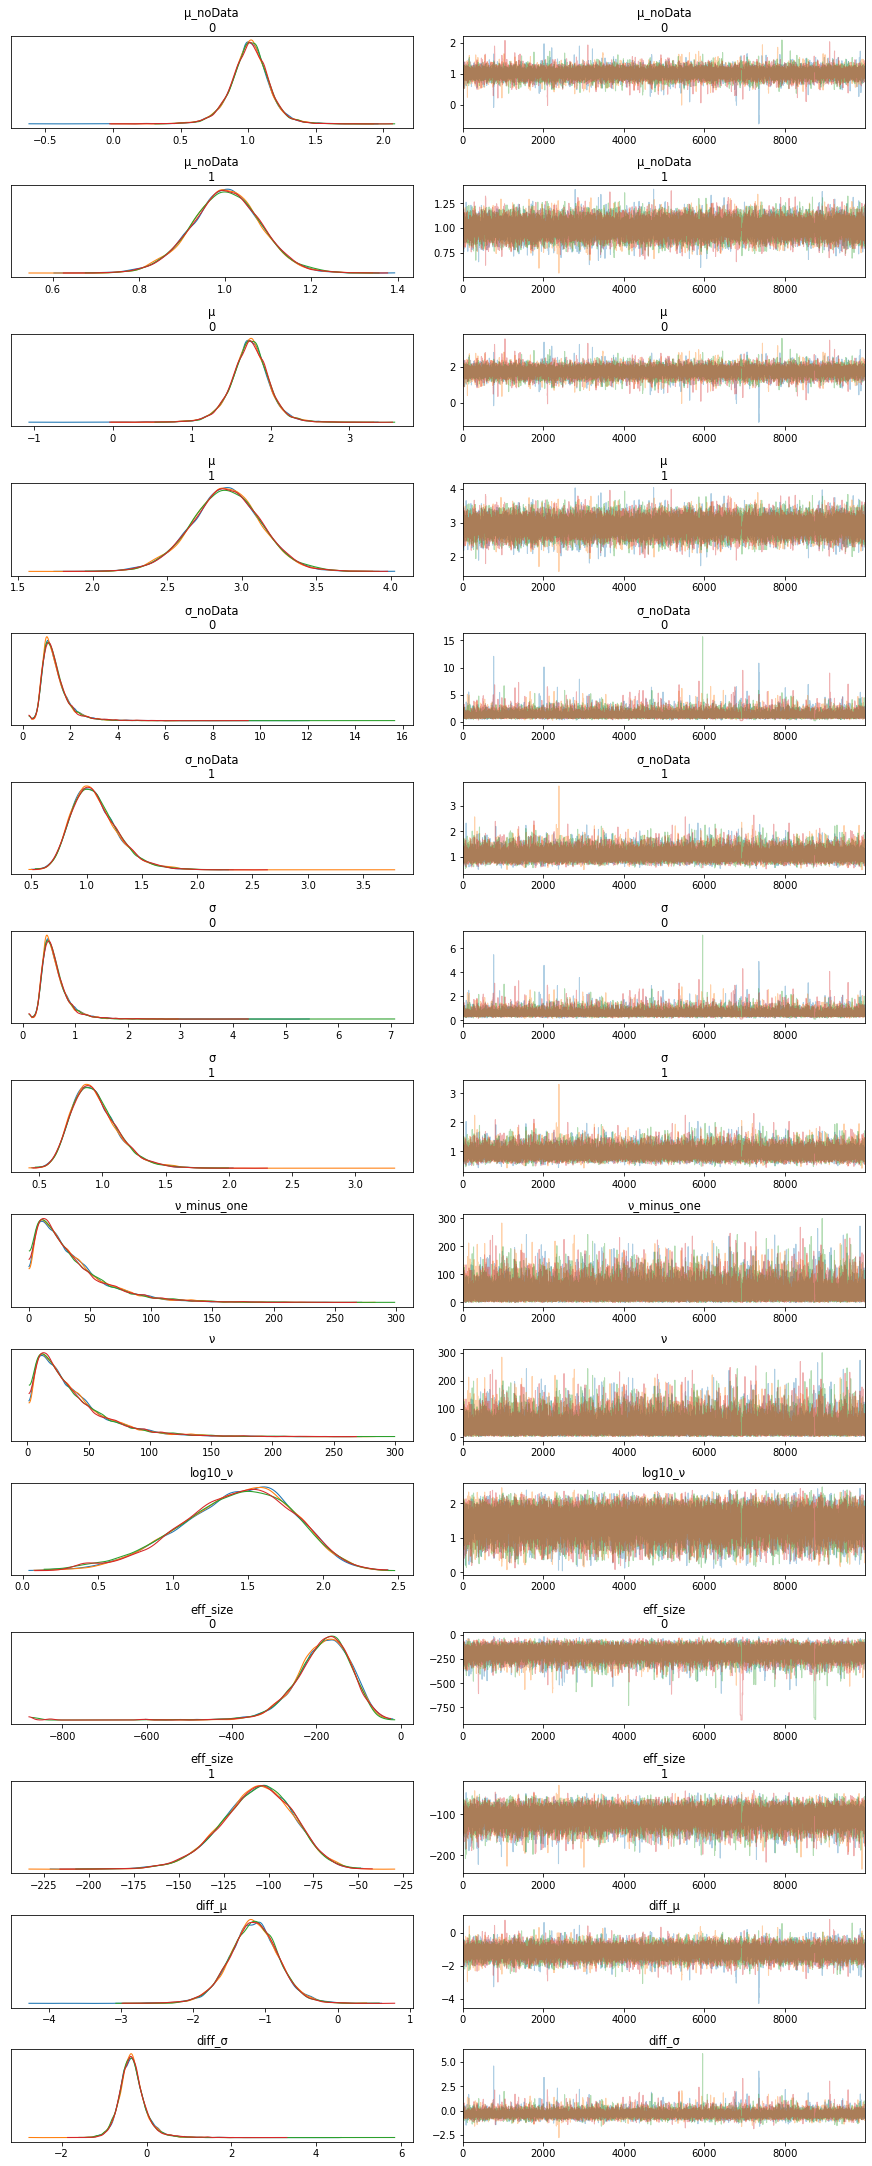

In [23]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

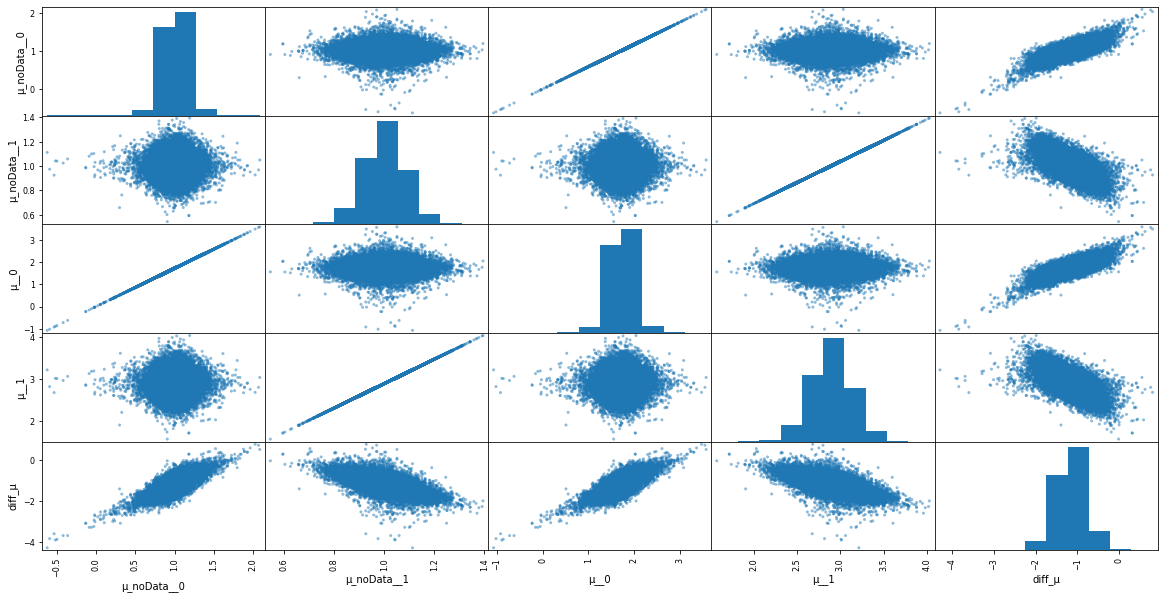

In [24]:
plot_trace_scatter(trace_h1_obs, ['μ_noData', 'μ', 'diff_μ'])

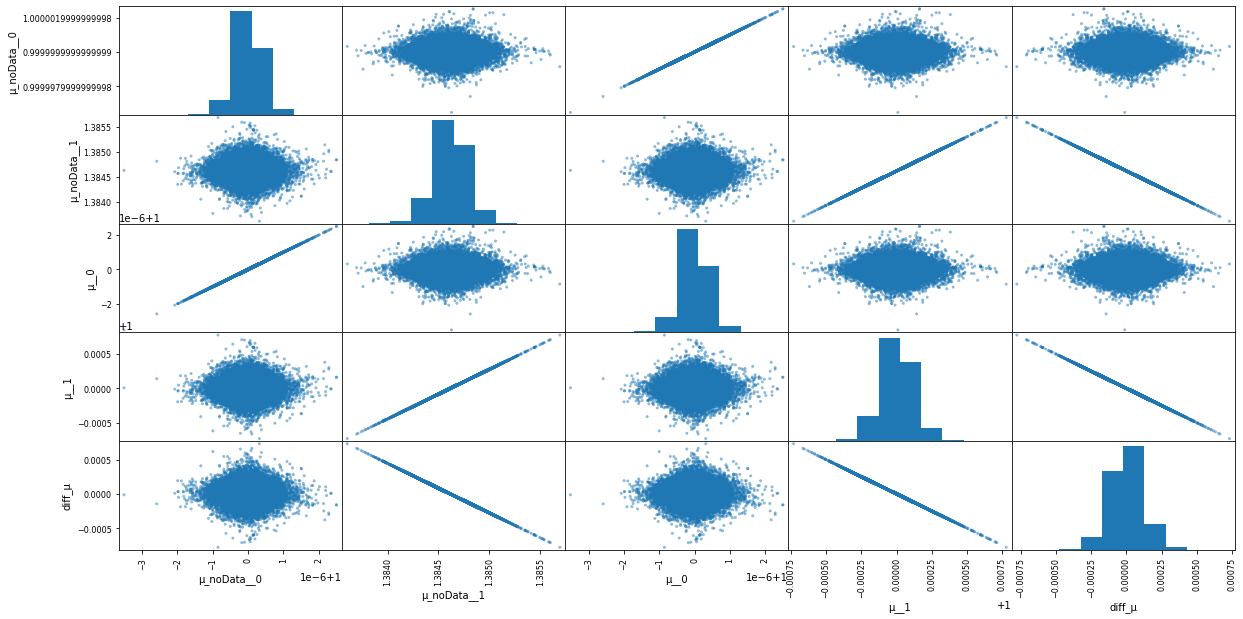

In [25]:
plot_trace_scatter(trace_h1_bern, ['μ_noData', 'μ', 'diff_μ'])

## H1 discussion

## H2

All communities show either a protective or equitable style of governance for pull requests (so for each community answers to V29 and V31 are different)

## Model h2

In [26]:
V29_norm = flatten([get_relevant(com, getIndexV29())[1] for com in communities])
V31_norm = flatten([get_relevant(com, getIndexV31())[1] for com in communities])
idxs = flatten([[i for v in get_relevant(com, getIndexV29())[1]] for (i,com) in enumerate(communities)])
com_ids = range(len(communities))
m_29 = np.mean(V29_norm)
m_31 = np.mean(V31_norm)
sd_29 = np.std(V29_norm)
sd_31 = np.std(V31_norm)
V29 = standardize(V29_norm, m_29, sd_29)
V31 = standardize(V31_norm, m_31, sd_31)

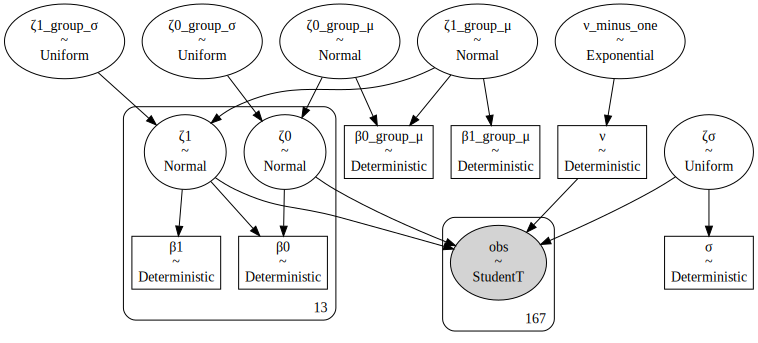

In [27]:
with pm.Model() as model_h2_linear:
    # Prior
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    
    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)
    
    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    
    
    pm.StudentT('obs',
            nu=ν,
            mu=ζ0[idxs]+ζ1[idxs]*V29,
            sigma=ζσ,
            observed=V31)
    
    #transforming data back
    β0 = pm.Deterministic('β0', (ζ0*sd_31) + m_31 - (ζ1*m_29*sd_31/sd_29))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29)
    
    
    β0_group_μ = pm.Deterministic('β0_group_μ', (ζ0_group_μ*sd_31) + m_31 - (ζ1_group_μ*m_29*sd_31/sd_29))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29)

    σ = pm.Deterministic('σ', ζσ)

pm.model_to_graphviz(model_h2_linear)

In [28]:
trace_h2_linear = getTrace(folderName_h2_linear, model_h2_linear, resample_h2_linear)  if h2_do_linear else None
trace_h2_inferencedata_linear = getInferenceData(trace_h2_linear, model_h2_linear)     if h2_do_linear else None

In [29]:
az.summary(trace_h2_linear) if h2_do_linear else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,-0.011,0.153,-0.278,0.282,0.011,0.007,213.0,213.0,185.0,10907.0,1.02
ζ1_group_μ,-0.127,0.111,-0.338,0.084,0.002,0.001,3280.0,2941.0,2577.0,2584.0,1.01
ζ0[0],-0.353,0.177,-0.688,-0.053,0.014,0.010,152.0,152.0,158.0,985.0,1.02
ζ0[1],0.085,0.181,-0.234,0.423,0.019,0.013,95.0,95.0,100.0,2202.0,1.03
ζ0[2],0.008,0.264,-0.494,0.504,0.015,0.010,317.0,317.0,311.0,10456.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
β1[11],-0.048,0.120,-0.268,0.181,0.006,0.004,362.0,362.0,353.0,1179.0,1.02
β1[12],-0.167,0.186,-0.550,0.170,0.002,0.003,6047.0,1685.0,5698.0,15762.0,1.06
β0_group_μ,2.541,0.448,1.732,3.450,0.008,0.007,2894.0,2152.0,2835.0,2018.0,1.06
β1_group_μ,-0.120,0.105,-0.321,0.080,0.002,0.001,3280.0,2941.0,2577.0,2584.0,1.01


In [69]:
var_names_h2_linear=['β0_group_μ','β1_group_μ','ν']

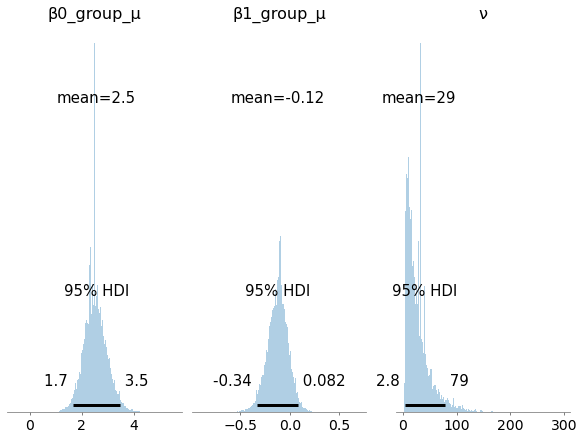

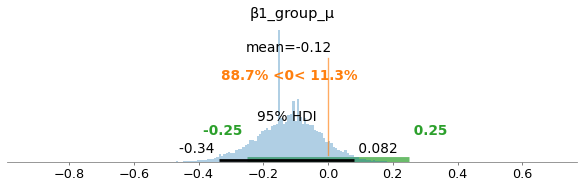

In [73]:
plot_trace_method1(trace_h2_inferencedata_linear, var_names_h2_linear, [("β1_group_μ", (-0.25, 0.25))])

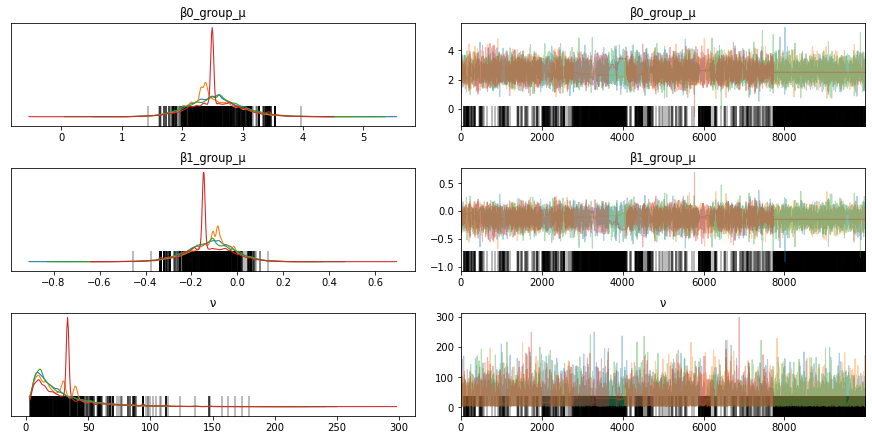

In [32]:
plot_trace_method2(trace_h2_linear, model_h2_linear, var_names_h2)

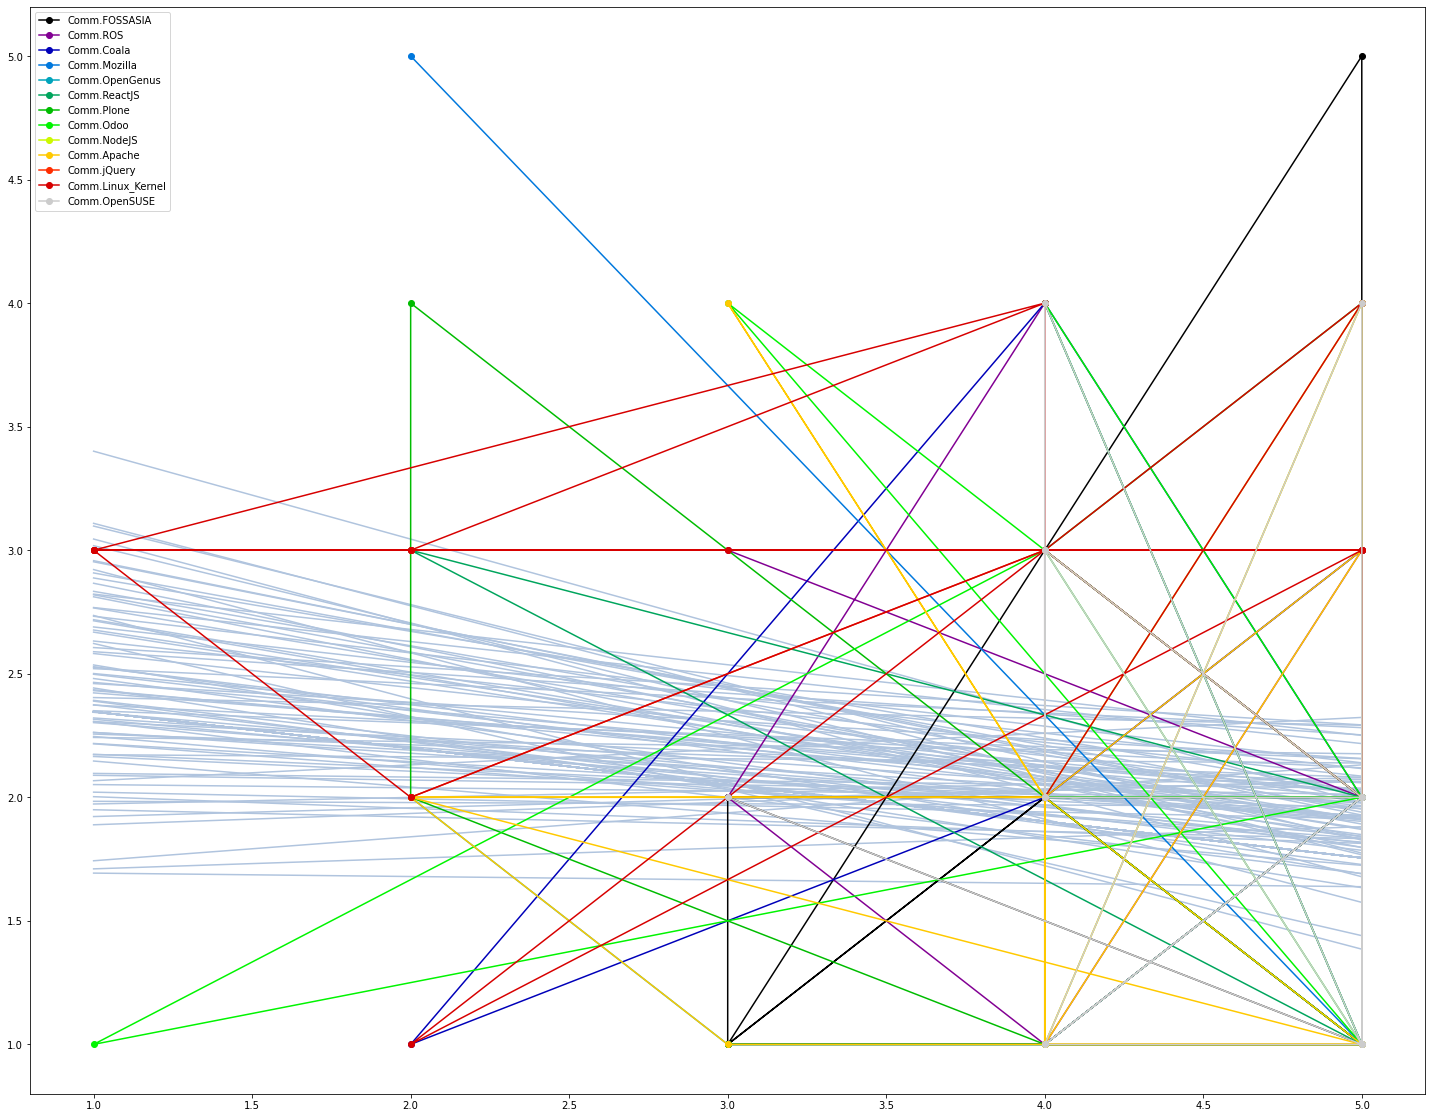

In [33]:
linFunction = lambda xprime, i: trace_h2_linear[i]['β0_group_μ']+trace_h2_linear[i]['β1_group_μ']*xprime
plot_all_data(linFunction)

In [34]:
def plot_com_reg_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29,
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot, 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], getIndexV29())[1], get_relevant(communities[com_id], getIndexV31())[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

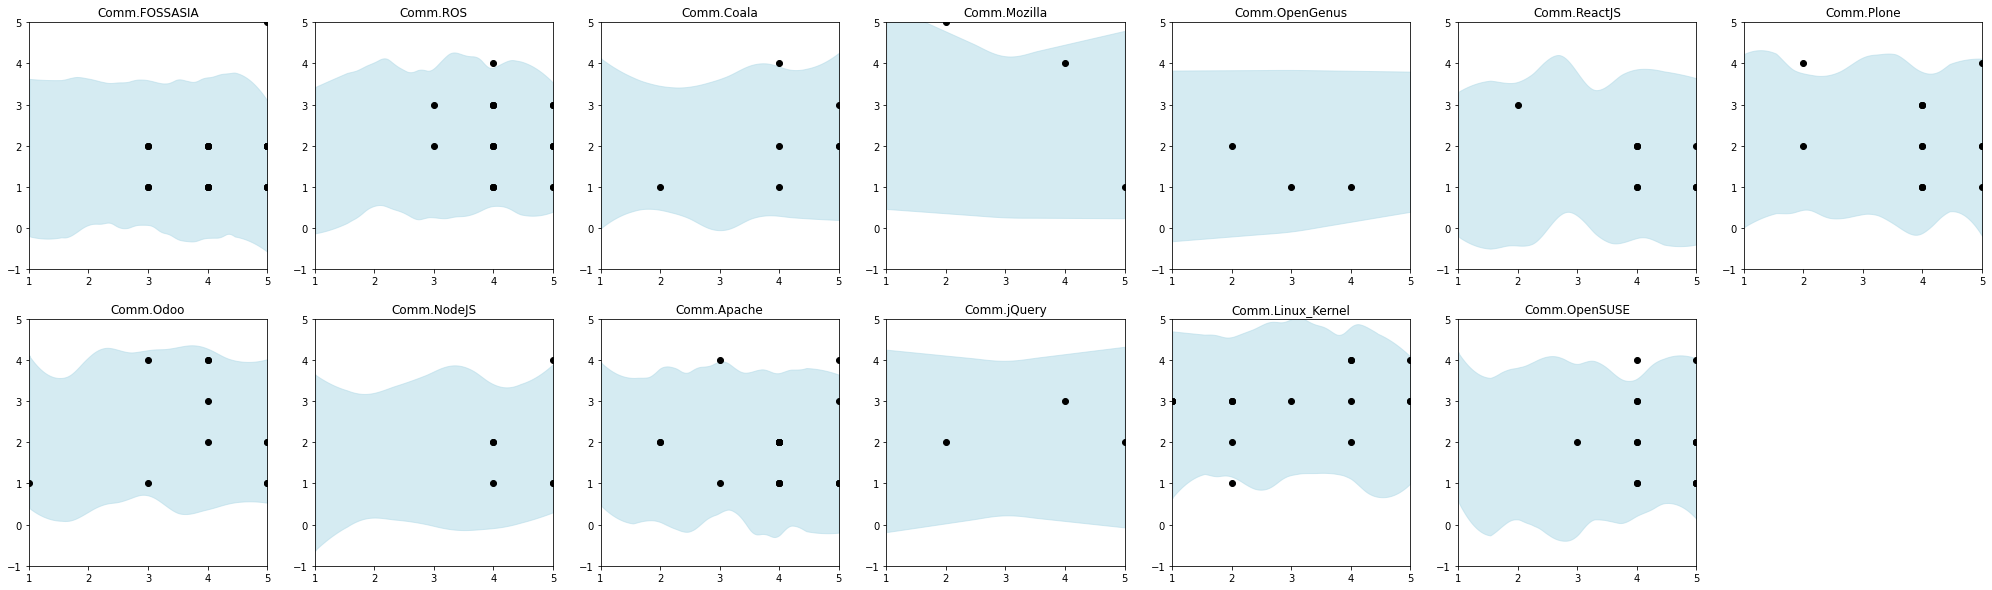

In [35]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_data(com_id=com_id,trace=trace_h2_linear,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()

### Quadratic

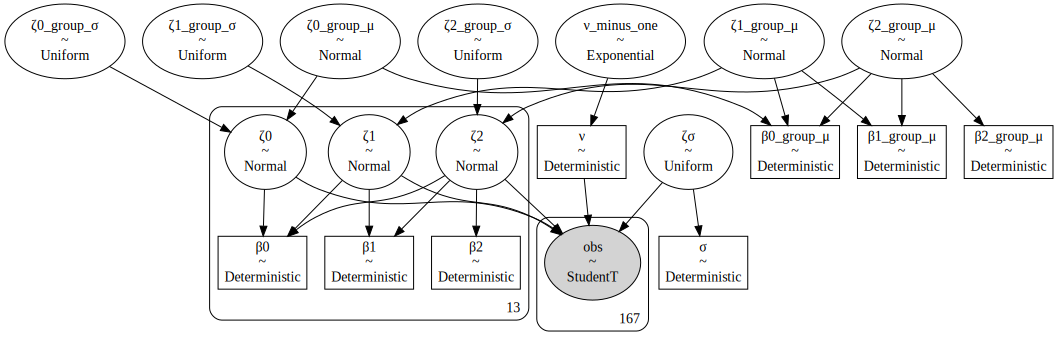

In [36]:
with pm.Model() as model_h2_quadratic:
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ2_group_μ = pm.Normal('ζ2_group_μ',mu=0,sigma=10)

    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    ζ2_group_σ = pm.Uniform('ζ2_group_σ',lower=1/1000,upper=1000)

    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)

    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    ζ2 = pm.Normal('ζ2',mu=ζ2_group_μ, sigma=ζ2_group_σ, shape=len(communities))

    pm.StudentT('obs',
                nu=ν,
                mu=ζ0[idxs]+ζ1[idxs]*V29+ζ2[idxs]*V29**2,
                sigma=ζσ,
                observed=V31)

    # Transform Data
    β2 = pm.Deterministic('β2', ζ2*sd_31/(sd_29**2))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29 - 2*ζ2*m_29*sd_31/(sd_29**2))
    β0 = pm.Deterministic('β0', ζ0*sd_31+m_31-ζ1*m_29*sd_31/sd_29+ζ2*(m_29**2)*sd_31/(sd_29**2))

    β2_group_μ = pm.Deterministic('β2_group_μ', ζ2_group_μ*sd_31/(sd_29**2))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29 - 2*ζ2_group_μ*m_29*sd_31/(sd_29**2))
    β0_group_μ = pm.Deterministic('β0_group_μ', ζ0_group_μ*sd_31+m_31-ζ1_group_μ*m_29*sd_31/sd_29+ζ2_group_μ*(m_29**2)*sd_31/(sd_29**2))

    σ = pm.Deterministic('σ', ζσ*sd_31)
pm.model_to_graphviz(model_h2_quadratic)

In [37]:
trace_h2_quadratic = getTrace(folderName_h2_quadratic, model_h2_quadratic, resample_h2_quadratic)  if h2_do_quadratic else None
trace_h2_inferencedata_quadratic = getInferenceData(trace_h2_quadratic, model_h2_quadratic)        if h2_do_quadratic else None

In [38]:
az.summary(trace_h2_quadratic) if h2_do_quadratic else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,0.028,0.170,-0.291,0.348,0.003,0.002,4066.0,4066.0,4026.0,4854.0,1.00
ζ1_group_μ,-0.137,0.133,-0.389,0.113,0.002,0.002,3277.0,3277.0,3122.0,9380.0,1.00
ζ2_group_μ,-0.017,0.095,-0.192,0.168,0.002,0.001,2730.0,2730.0,2602.0,11939.0,1.00
ζ0[0],-0.368,0.188,-0.707,-0.005,0.004,0.003,2389.0,2389.0,2405.0,7470.0,1.00
ζ0[1],0.108,0.189,-0.249,0.453,0.005,0.004,1261.0,1261.0,1270.0,9734.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
β0[12],1.951,2.696,-3.297,7.108,0.027,0.019,9788.0,9788.0,8683.0,15130.0,1.00
β2_group_μ,-0.015,0.086,-0.173,0.151,0.002,0.001,2730.0,2730.0,2602.0,11939.0,1.00
β1_group_μ,-0.009,0.655,-1.270,1.199,0.012,0.009,2911.0,2911.0,2710.0,7046.0,1.00
β0_group_μ,2.378,1.263,-0.132,4.643,0.024,0.017,2737.0,2737.0,2492.0,2131.0,1.00


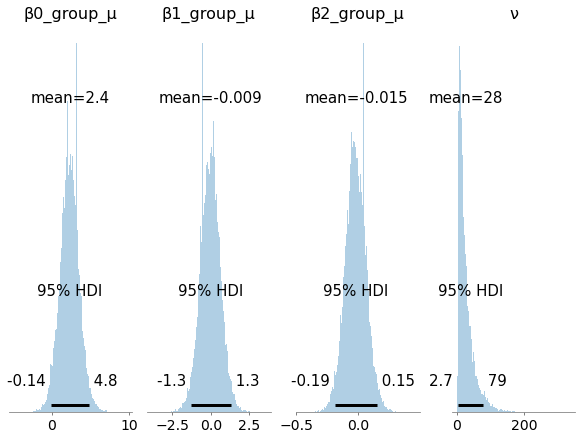

In [39]:
var_names_h2=['β0_group_μ','β1_group_μ','β2_group_μ','ν']
plot_trace_method1(trace_h2_inferencedata_quadratic, var_names_h2, [])

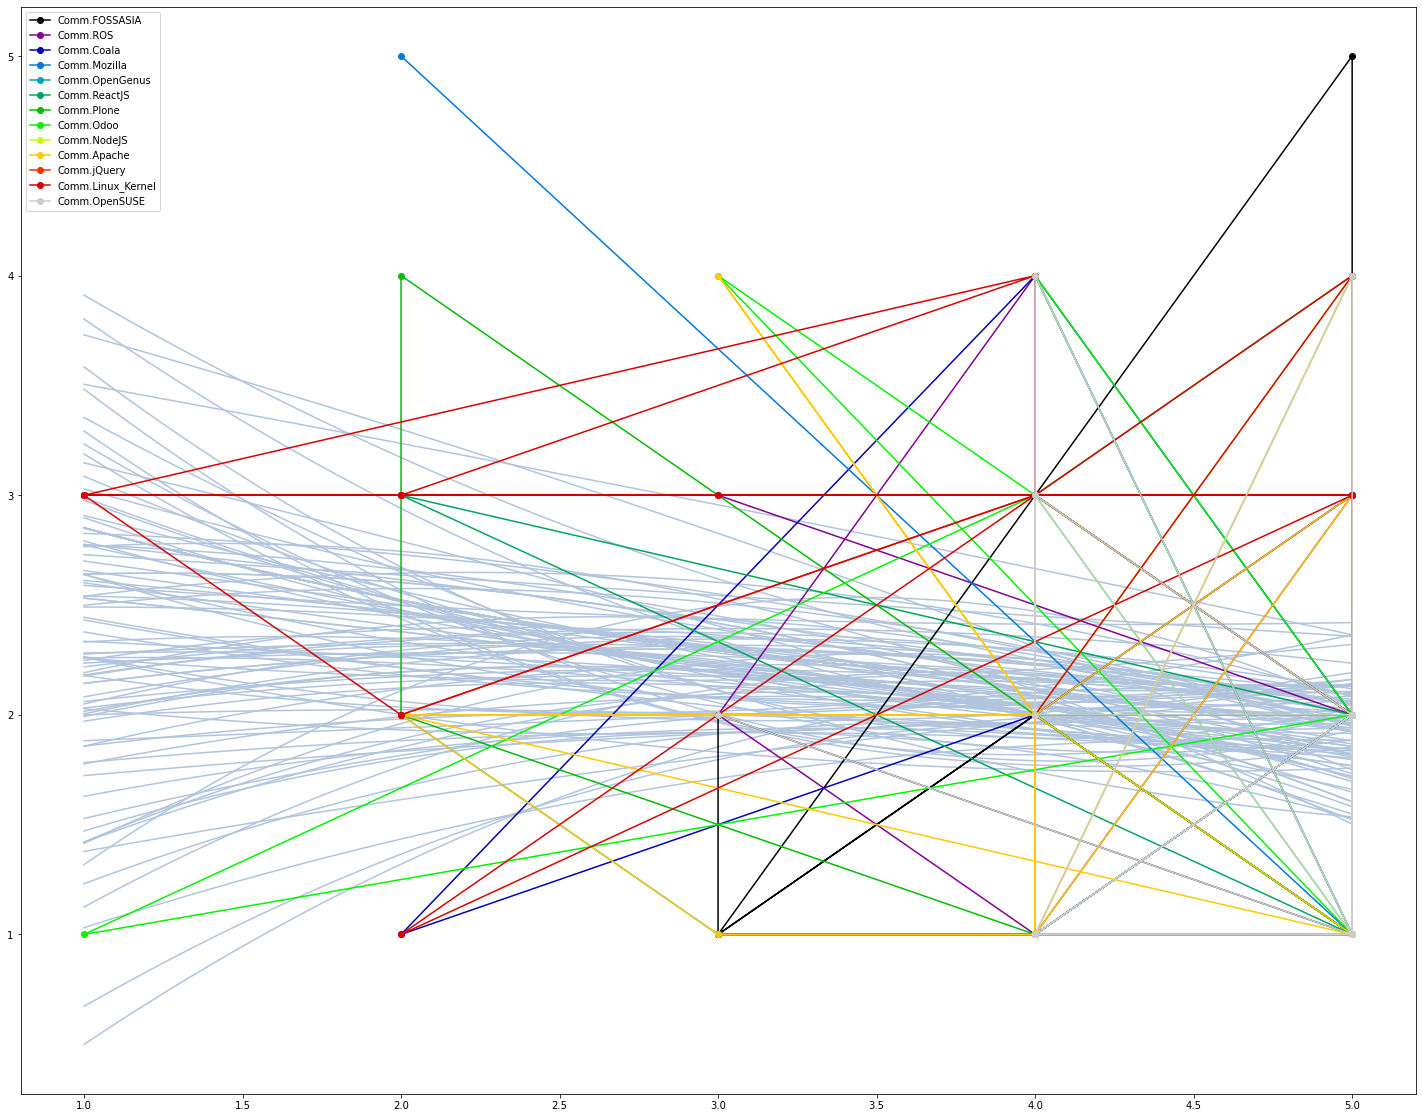

In [40]:
quadraticFunction = lambda xprime, i: trace_h2_quadratic[i]['β0_group_μ']+trace_h2_quadratic[i]['β1_group_μ']*xprime+trace_h2_quadratic[i]['β2_group_μ']*xprime**2
plot_all_data(quadraticFunction)

In [41]:
def plot_com_reg_quadratic_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2),
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2), 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], getIndexV29())[1], get_relevant(communities[com_id], getIndexV31())[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

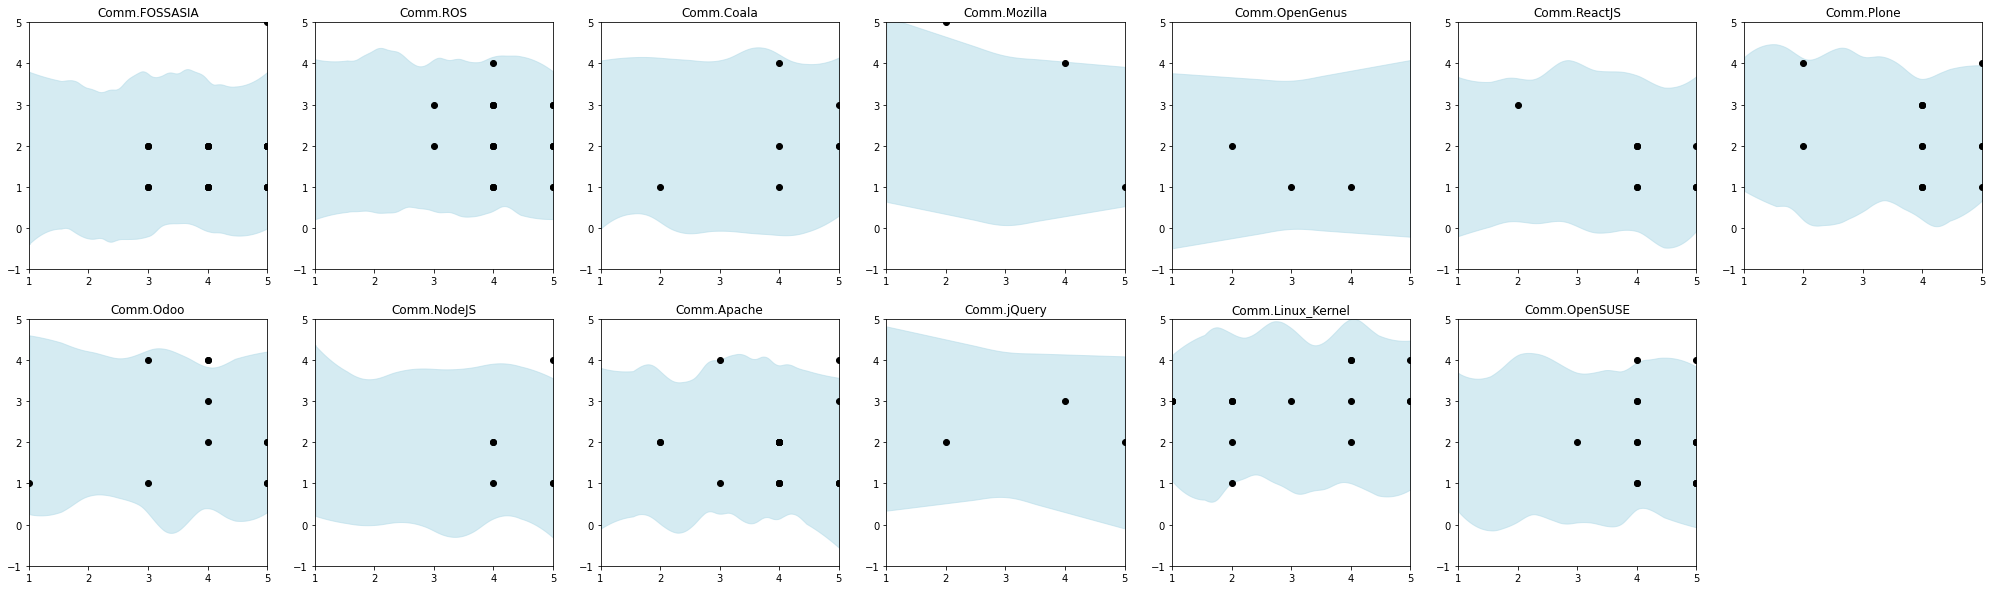

In [42]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_quadratic_data(com_id=com_id,trace=trace_h2_quadratic,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()